# Johns Hopkins COVID-19 Global Time Series

### Gather time series .csv's from the JHU GitHub to create a time series

#### Calvin D'Souza

---

[JHU COVID-19 Time Series Data](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

---

Task List:
- [x] Extract and Combine 3 CSV Files (Confirmed, Deaths, Recovered)
- [x] Convert Date columns to rows (wide to long)
- [x] Plot Time series
- [ ] Normalize (deaths/mil)
- [ ] Automate/Schedule new data retrieval
- [ ] df to google sheets (set up API & get credentials)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(14, 9)})
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime as dt
import requests

## Gather Data

In [2]:
# List to hold the names of dfs. 
# DF names correspond to the ending URL of each individual csv
df_names = ['confirmed_global', 'deaths_global', 'recovered_global'] 

# List to hold 3 empty dfs
df_list = [pd.DataFrame() for df in df_names]

# Dictionary with key:value pair as df_names: df_list
df_dict = dict(zip(df_names, df_list))

url_part = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_'

### Convert Wide to Long

In [3]:
for key, value in df_dict.items():
    value = pd.read_csv(url_part+key+'.csv', parse_dates=[0])
    
    # Rename columns with '/'
    value.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'}, inplace=True)
    
    # Columns to use as identifier variables.
    dim_col = value.columns[0:4]
    
    # Columns to unpivot
    date_col = value.columns[4:]
    
    # melt() unpivots all the date columns from wide format to long format with heading of these columns being fed to a new column ‘Date’
    value = value.melt(id_vars = dim_col, value_vars = date_col, var_name = 'Date', value_name = key)
    
    # convert object to datetime
    value['Date'] = pd.to_datetime(value['Date'])
    
    df_dict[key] = value

### Merge 3 dfs into 1

In [4]:
# merge 3 different files having ‘Province_State’, ‘Country_Region’, ‘Lat’, ‘Long’, ‘Date’ in common
join_on_col = ['Province_State','Country_Region','Lat','Long','Date']

df_COVID = df_dict['confirmed_global'].merge(df_dict['deaths_global'], on=join_on_col, how='outer').merge(df_dict['recovered_global'], on=join_on_col, how='outer')
df_COVID.rename(columns = {'confirmed_global':'Confirmed', 'deaths_global':'Deaths', 'recovered_global':'Recovered'}, inplace = True)

### A little bit of cleaning

In [5]:
# fill the NaN in 'Province_State' columns with Countries name in 'Country_Region'
df_COVID['Province_State'] = np.where(df_COVID['Province_State'] == 'nan', df_COVID['Country_Region'], df_COVID['Province_State'])

# fill the NaN in last three columns (Confirmed, Deaths, Recovered) with 0
df_COVID.iloc[0:,-3:] = df_COVID.iloc[0:,-3:].fillna(0)

# remove Lat and Long
df_COVID1 = df_COVID.drop(columns=['Lat', 'Long'])
df_COVID = df_COVID1
df_COVID

,Province_State,Country_Region,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,2020-01-22,0.0,0.0,0.0
1,NaN,Albania,2020-01-22,0.0,0.0,0.0
2,NaN,Algeria,2020-01-22,0.0,0.0,0.0
3,NaN,Andorra,2020-01-22,0.0,0.0,0.0
4,NaN,Angola,2020-01-22,0.0,0.0,0.0
...,...,...,...,...,...,...
124875,Hebei,China,2021-04-11,0.0,0.0,1310.0
124876,Henan,China,2021-04-11,0.0,0.0,1284.0
124877,NaN,Mozambique,2021-04-11,0.0,0.0,58904.0
124878,NaN,Syria,2021-04-11,0.0,0.0,14012.0


## Individual Countries

### France Data

In [6]:
France_data_1 = df_COVID[(df_COVID['Country_Region'] == 'France')]
France_data = France_data_1.groupby('Date').sum()
France_data.reset_index(level=0, inplace=True)
France_data

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0
2,2020-01-24,2.0,0.0,0.0
3,2020-01-25,3.0,0.0,0.0
4,2020-01-26,3.0,0.0,0.0
...,...,...,...,...
441,2021-04-07,4902985.0,97444.0,308128.0
442,2021-04-08,5000155.0,98196.0,312540.0
443,2021-04-09,5000314.0,98202.0,312540.0
444,2021-04-10,5001685.0,98213.0,312540.0


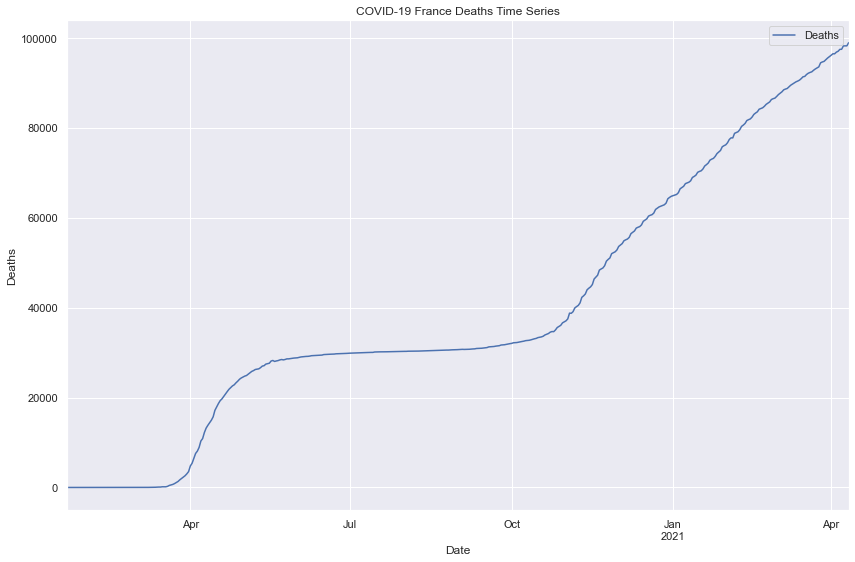

In [7]:
France_data.plot(kind='line', x='Date', y='Deaths')
plt.title("COVID-19 France Deaths Time Series")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.savefig('jhu_france_deaths_ts.png', bbox_inches='tight')

### China Data

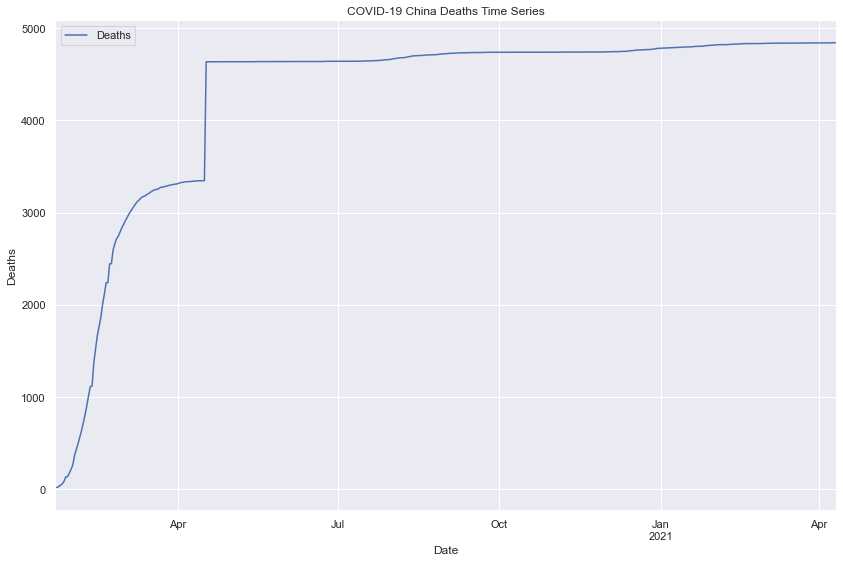

In [8]:
China_data_1 = df_COVID[(df_COVID['Country_Region'] == 'China')]
China_data = China_data_1.groupby('Date').sum()
China_data.reset_index(level=0, inplace=True)
China_data.plot(kind='line', x='Date', y='Deaths')
plt.title("COVID-19 China Deaths Time Series")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.savefig('jhu_china_deaths_ts.png', bbox_inches='tight')

### US Data

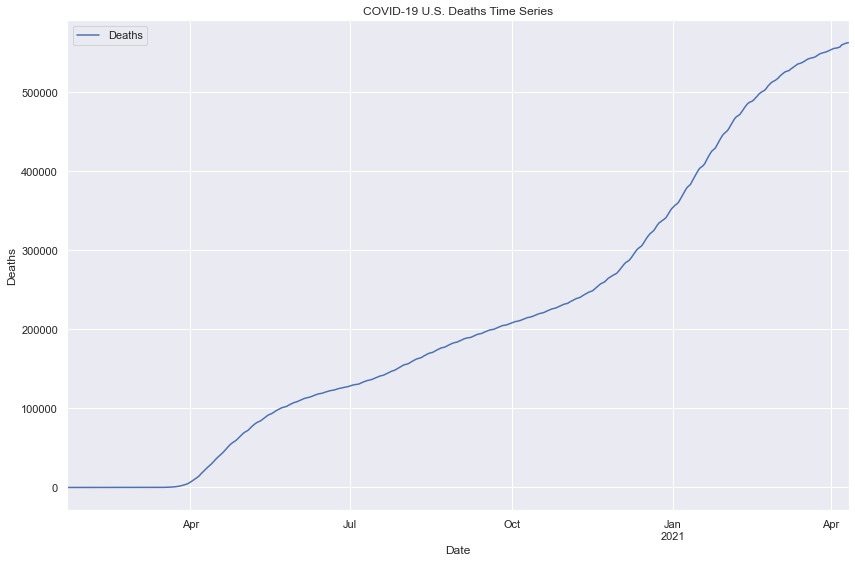

In [9]:
US_data_1 = df_COVID[(df_COVID['Country_Region'] == 'US')]
US_data = US_data_1.groupby('Date').sum()
US_data.reset_index(level=0, inplace=True)
US_data.plot(kind='line', x='Date', y='Deaths')
plt.title("COVID-19 U.S. Deaths Time Series")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.savefig('jhu_usa_deaths_ts.png', bbox_inches='tight')

### Brazil Data

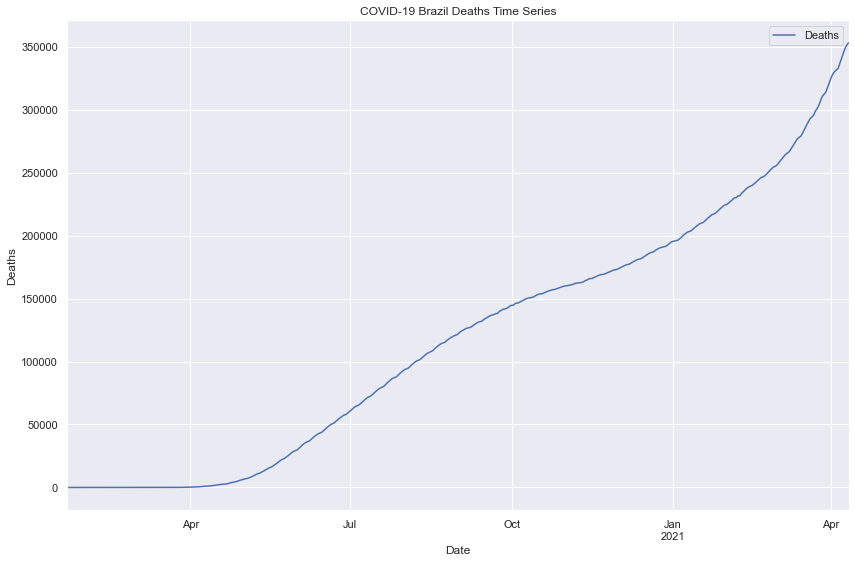

In [10]:
Brazil_data_1 = df_COVID[(df_COVID['Country_Region'] == 'Brazil')]
Brazil_data = Brazil_data_1.groupby('Date').sum()
Brazil_data.reset_index(level=0, inplace=True)
Brazil_data.plot(kind='line', x='Date', y='Deaths')
plt.title("COVID-19 Brazil Deaths Time Series")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.savefig('jhu_brazil_deaths_ts.png', bbox_inches='tight')

### Italy Data

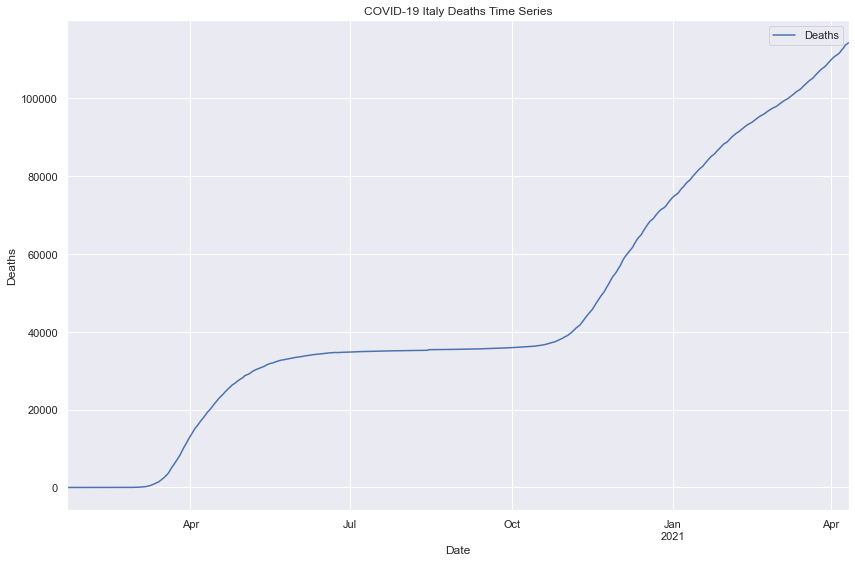

In [11]:
Italy_data_1 = df_COVID[(df_COVID['Country_Region'] == 'Italy')]
Italy_data = Italy_data_1.groupby('Date').sum()
Italy_data.reset_index(level=0, inplace=True)
Italy_data.plot(kind='line', x='Date', y='Deaths')
plt.title("COVID-19 Italy Deaths Time Series")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.savefig('jhu_italy_deaths_ts.png', bbox_inches='tight')

### Japan Data

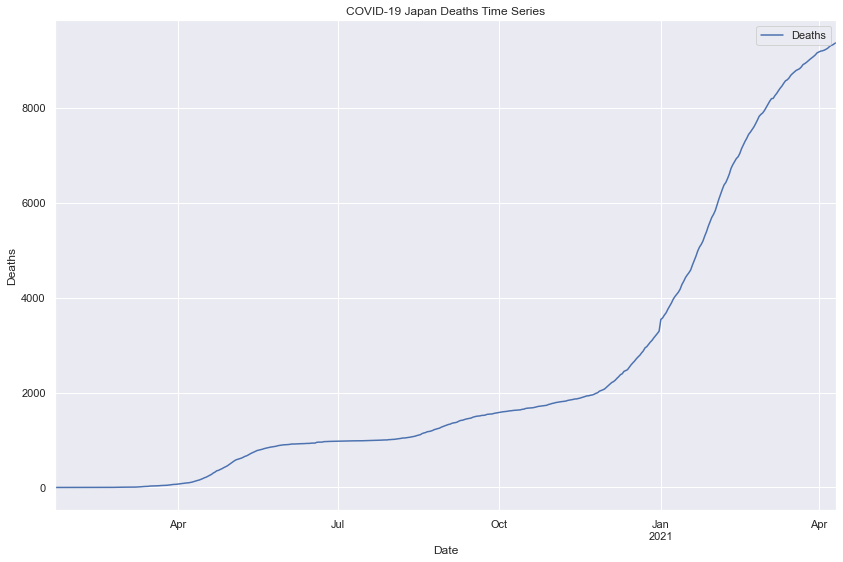

In [12]:
Japan_data_1 = df_COVID[(df_COVID['Country_Region'] == 'Japan')]
Japan_data = Japan_data_1.groupby('Date').sum()
Japan_data.reset_index(level=0, inplace=True)
Japan_data.plot(kind='line', x='Date', y='Deaths')
plt.title("COVID-19 Japan Deaths Time Series")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.savefig('jhu_japan_deaths_ts.png', bbox_inches='tight')

## Deaths All Countries

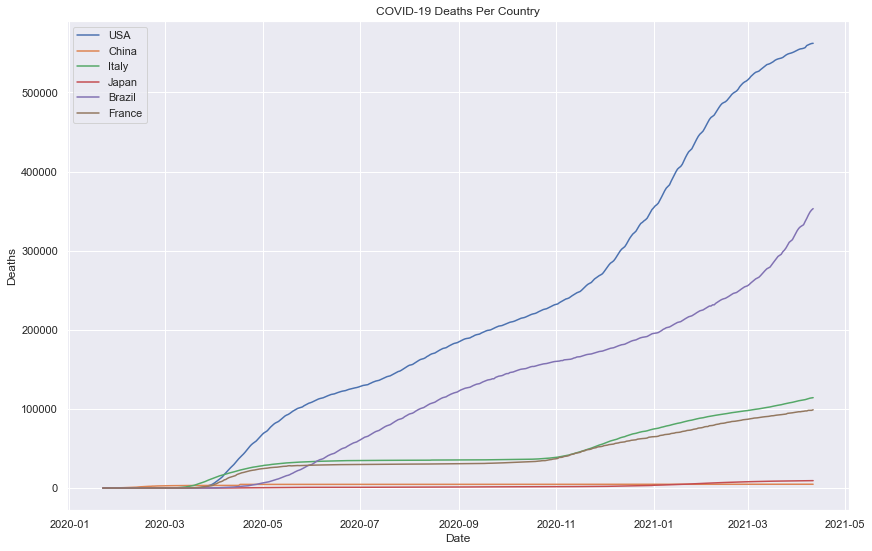

In [13]:
plt.plot(US_data['Date'], US_data['Deaths'], label="USA")
plt.plot(China_data['Date'], China_data['Deaths'], label="China")
plt.plot(Italy_data['Date'], Italy_data['Deaths'], label="Italy")
plt.plot(Japan_data['Date'], Japan_data['Deaths'], label="Japan")
plt.plot(Brazil_data['Date'], Brazil_data['Deaths'], label="Brazil")
plt.plot(France_data['Date'], France_data['Deaths'], label="France")

plt.title("COVID-19 Deaths Per Country")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend(loc="upper left")
plt.savefig('jhu_all_countries_deaths_ts.png', bbox_inches='tight')

In [ ]:
# Next up: Automate Job